# Virtual Logit Matching (VIM) method

This notebook aims at evaluating the **VIM method**.

The method consists in analysing the projection of an input image in a feature subspace
that contains the least information about in-distribution data. It is achieved by
performing a PCA on the in-distribution dataset in the feature space. The norm of the
projection of a new input data's feature representation onto the principal vectors
explaining the least variance is then used for scoring.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**
[ViM: Out-Of-Distribution with Virtual-logit Matching](http://arxiv.org/abs/2203.10807),
CVPR 2022.


### Imports


In [1]:
%load_ext autoreload

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.methods import VIM
from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset
from oodeel.models.training_funs_tf import train_keras_app

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First experiment: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the VIM
method, we will compare the scores returned for MNIST[0-4] (in-distribution) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODModel`.


In [3]:
# === Load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- Load train/test MNIST dataset
ds_train = OODDataset("mnist", load_kwargs=dict(split="train"))
data_test = OODDataset("mnist", load_kwargs=dict(split="test"))

# 2- Split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
ds_train, _ = ds_train.assign_ood_labels_by_class(in_labels)
oods_in, oods_out = data_test.assign_ood_labels_by_class(in_labels)


# 3- Prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_train = ds_train.prepare(batch_size, preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size, preprocess_fn, with_ood_labels=False)
ds_out = oods_out.prepare(batch_size, preprocess_fn, with_ood_labels=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model training

Now let's train a simple model on MNIST[0-4] using `train_keras_app` function.


In [4]:
# === Train / Load model ===
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    # if the model exists, load it
    model = tf.keras.models.load_model(model_path_mnist_04)
except OSError:
    # else, train a new model
    train_config = {
        "model_name": "toy_convnet",
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }

    model = train_keras_app(ds_train, **train_config)

_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

41/41 [==============================] - 2s 10ms/step - loss: 0.0120 - accuracy: 0.9969
Test accuracy:	0.9969


### VIM score

We now fit a VIM OOD detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


auroc      0.963237
fpr95tpr   0.138354


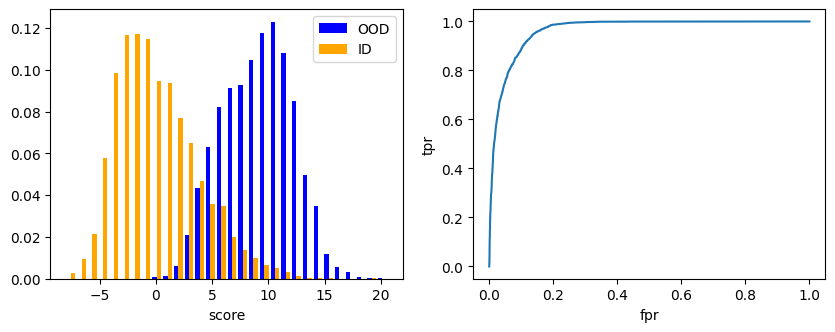

In [5]:
# === VIM scores ===
oodmodel = VIM(princ_dims=500)
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# === Metrics===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

# ROC
fpr, tpr, _, _ = get_curve(
    scores=np.concatenate([scores_in, scores_out]),
    labels=np.concatenate([scores_in * 0 + 0, scores_out * 0 + 1]),
)

# Plot histograms of OOD scores and ROC
# plot hists / roc
plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.hist(
    x=(scores_out, scores_in),
    bins=30,
    color=("blue", "orange"),
    label=("OOD", "ID"),
    density=True,
)
plt.xlabel("score")
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Second experiment: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [6]:
# === Load ID and OOD data ===
batch_size = 128

# 1a- Load in-distribution dataset: CIFAR-10
ds_fit = OODDataset("cifar10", load_kwargs={"split": "train"}, input_key="image")
ds_in = OODDataset("cifar10", load_kwargs={"split": "test"}, input_key="image")

# 1b- Load out-of-distribution dataset: SVHN
ds_out = OODDataset("svhn_cropped", load_kwargs={"split": "test"})


# 2- prepare data (preprocess, shuffle, batch)
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


ds_fit = ds_fit.prepare(batch_size, preprocess_fn)
ds_in = ds_in.prepare(batch_size, preprocess_fn)
ds_out = ds_out.prepare(batch_size, preprocess_fn)

### Model loading

The model is a **ResNet** pretrained on CIFAR-10 and getting an accuracy score of
92.75%.


In [7]:
# === Load model ===
# ResNet pretrained on CIFAR-10
model_path_resnet_cifar10 = tf.keras.utils.get_file(
    "cifar10_resnet256.h5",
    origin="https://share.deel.ai/s/kram9kLpx6JwRX4/download/cifar10_resnet256.h5",
    cache_dir=model_path,
    cache_subdir="",
)
model = tf.keras.models.load_model(model_path_resnet_cifar10)

# Evaluate model
model.compile(metrics=["accuracy"])
_, accuracy = model.evaluate(ds_in)
print(f"Test accuracy:\t{accuracy:.4f}")

79/79 [==============================] - 2s 13ms/step - loss: 0.1268 - accuracy: 0.9275
Test accuracy:	0.9275


### VIM score

We now fit a VIM OOD detector with CIFAR-10 train dataset, and compare OOD scores
returned for CIFAR-10 (ID) and SVHN (OOD) test datasets.


auroc      0.951808
fpr95tpr   0.154300


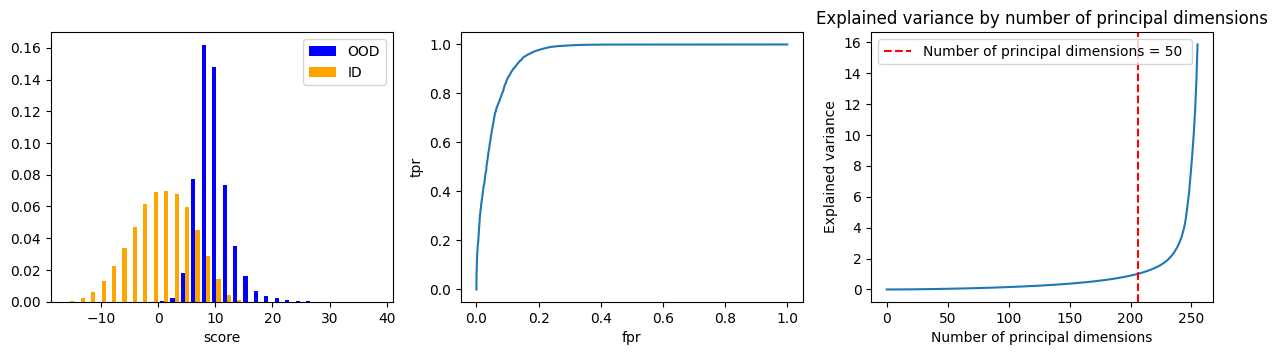

In [14]:
# === VIM scores ===
oodmodel = VIM(princ_dims=50)
oodmodel.fit(model, ds_fit)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# === Metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

# ROC
fpr, tpr, _, _ = get_curve(
    scores=np.concatenate([scores_in, scores_out]),
    labels=np.concatenate([scores_in * 0 + 0, scores_out * 0 + 1]),
)

# Plot histograms of OOD scores and ROC
plt.figure(figsize=(15, 3.5))
plt.subplot(131)
plt.hist(
    x=(scores_out, scores_in),
    bins=30,
    color=("blue", "orange"),
    label=("OOD", "ID"),
    density=True,
)
plt.xlabel("score")
plt.legend()
plt.subplot(132)
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.subplot(133)
oodmodel.plot_spectrum()
plt.show()